# Library

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

from prince import MCA

from sklearn.decomposition import PCA
from sklearn.cross_decomposition import CCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.model_selection import train_test_split
from sklearn.metrics import silhouette_samples, silhouette_score, classification_report, confusion_matrix

# Data

In [ ]:
df = pd.read_csv(
    r'../../data/',
    encoding='utf-8',
)

In [61]:
df.columns = df.columns.str.strip().str.lower().str.replace(' ', '_')

In [62]:
df.head()

,temperature,humidity,wind_speed,precipitation_(%),atmospheric_pressure,visibility_(km),cloud_cover,season,location,uv_index,weather_type
0,14.0,73,9.5,82.0,1010.82,3.5,partly cloudy,Winter,inland,2,1
1,39.0,96,8.5,71.0,1011.43,10.0,partly cloudy,Spring,inland,7,0
2,30.0,64,7.0,16.0,1018.72,5.5,clear,Spring,mountain,5,3
3,38.0,83,1.5,82.0,1026.25,1.0,clear,Spring,coastal,7,3
4,27.0,74,17.0,66.0,990.67,2.5,overcast,Winter,mountain,1,1


# Load metadata

In [ ]:
df = load_metadata(
    df,
    r"/data\metadata\metadata3.json",
)

# Overview

## Check

In [64]:
print(f"Num of varibles:", df.shape[1])
print(f"Num of rows:", df.shape[0])

Num of varibles: 11
Num of rows: 13200


In [65]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13200 entries, 0 to 13199
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype   
---  ------                --------------  -----   
 0   temperature           13200 non-null  float64 
 1   humidity              13200 non-null  int64   
 2   wind_speed            13200 non-null  float64 
 3   precipitation_(%)     13200 non-null  float64 
 4   atmospheric_pressure  13200 non-null  float64 
 5   visibility_(km)       13200 non-null  float64 
 6   cloud_cover           13200 non-null  object  
 7   season                13200 non-null  category
 8   location              13200 non-null  object  
 9   uv_index              13200 non-null  int64   
 10  weather_type          13200 non-null  int64   
dtypes: category(1), float64(5), int64(3), object(2)
memory usage: 1.0+ MB


In [66]:
df.isnull().sum()

temperature             0
humidity                0
wind_speed              0
precipitation_(%)       0
atmospheric_pressure    0
visibility_(km)         0
cloud_cover             0
season                  0
location                0
uv_index                0
weather_type            0
dtype: int64

## Varibles and target

In [ ]:
target = ['']
variablies = df.columns.tolist()
variablies.remove(target[0])

df_target = df[target].copy()
df = df[variablies].copy()

print(target)
print(variablies)

['weather_type']
['temperature', 'humidity', 'wind_speed', 'precipitation_(%)', 'atmospheric_pressure', 'visibility_(km)', 'cloud_cover', 'season', 'location', 'uv_index']


# Grouping Varibles by their respective data types (except target)

In [68]:
numerical_cols, categorical_cols, _ = group_columns_by_type(df, display_info=True)

Total numeric columns: 7
Numeric columns: ['temperature', 'humidity', 'wind_speed', 'precipitation_(%)', 'atmospheric_pressure', 'visibility_(km)', 'uv_index']

Total categorical columns: 3
Categorical columns: ['cloud_cover', 'season', 'location']



# Multivariate

In [69]:
df_numerical = df[numerical_cols].copy()
df_categorical = df[categorical_cols].copy()

## Visualization and dimensionality reduction

### PCA

In [70]:
# Normalization
X_scaled = preprocessing_numerical(df, numerical_cols)

#### Selection `n_components`

In [71]:
n_components_pca_full = min(df_numerical.shape[0], df_numerical.shape[1])

In [72]:
pca_full = PCA(n_components=n_components_pca_full, random_state=42)
X_pca_full = pca_full.fit_transform(X_scaled)

In [73]:
explained_var = pca_full.explained_variance_ratio_
eigenvalues = pca_full.explained_variance_
cum_var = np.cumsum(explained_var)

summary_df = pd.DataFrame(
        {
            "eigenvalue": eigenvalues,
            "variance_%": explained_var * 100,
            "variance_(cumulative)_%": cum_var * 100,
        }
    )

summary_df.index = [f"PC{i+1}" for i in range(len(explained_var))]
summary_df.round(2)

,eigenvalue,variance_%,variance_(cumulative)_%
PC1,2.80,39.99,39.99
PC2,1.18,16.90,56.89
PC3,0.91,12.94,69.84
PC4,0.67,9.54,79.38
PC5,0.56,7.98,87.36
PC6,0.54,7.74,95.10
PC7,0.34,4.90,100.00


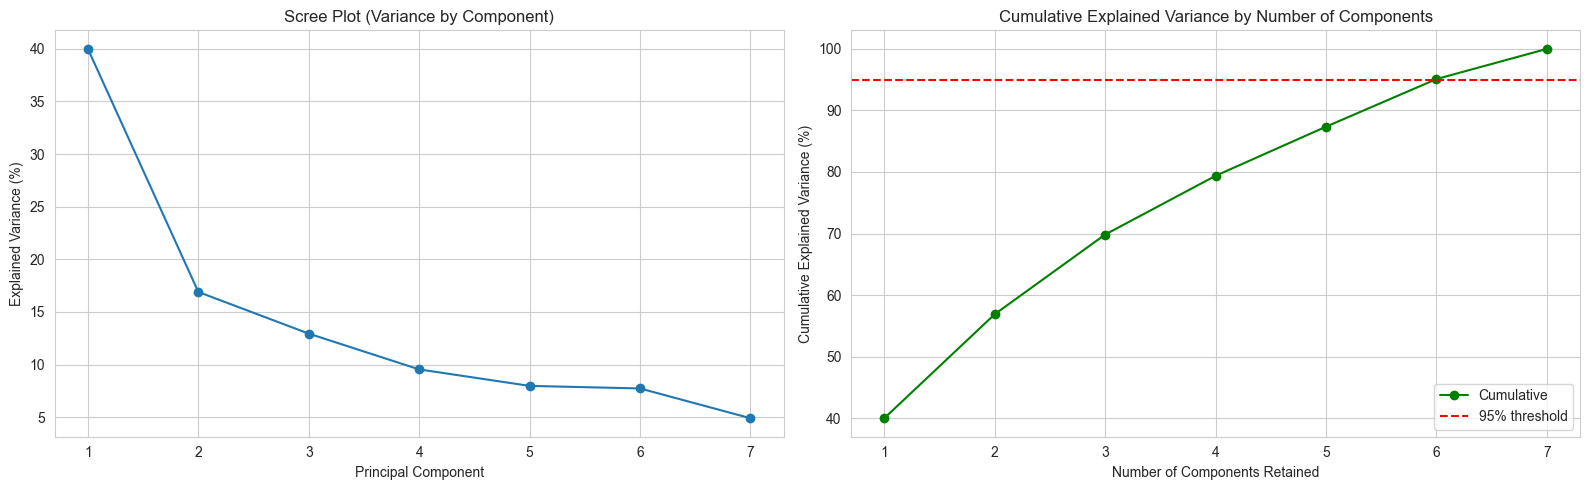

In [74]:
plot_pca_contributions(pca_full, 0.95)

#### Main

In [75]:
pca = PCA(n_components=6, random_state=42)
X_pca = pca.fit(X_scaled)

In [76]:
loadings = pca.components_.T * np.sqrt(pca.explained_variance_)
loadings

array([[-0.50010208,  0.59072425, -0.10033583,  0.60081911,  0.06925488,
        -0.12838301],
       [ 0.79427829,  0.24359376,  0.06331799,  0.13027556,  0.34652689,
         0.1056978 ],
       [ 0.55838434,  0.55143014, -0.24968194, -0.28898225, -0.25623761,
        -0.41400954],
       [ 0.80764016,  0.20946953, -0.06582902, -0.08570215,  0.30776213,
         0.16966536],
       [-0.313008  ,  0.44272426,  0.8109391 , -0.21771784,  0.02002321,
         0.00362484],
       [-0.72145875, -0.0555783 , -0.18638837, -0.28161938,  0.51902676,
        -0.30446516],
       [-0.57976507,  0.47720362, -0.36475687, -0.26950797, -0.05974413,
         0.47007772]])

In [77]:
get_pca_contribution_table(
    pca,
    variable_names=numerical_cols,
    percent=True
)

,PC1,PC2,PC3,PC4,PC5,PC6
temperature,8.93 %,29.5 %,1.11 %,54.03 %,0.86 %,3.04 %
humidity,22.53 %,5.02 %,0.44 %,2.54 %,21.5 %,2.06 %
wind_speed,11.14 %,25.7 %,6.88 %,12.5 %,11.75 %,31.65 %
precipitation_(%),23.3 %,3.71 %,0.48 %,1.1 %,16.96 %,5.32 %
atmospheric_pressure,3.5 %,16.57 %,72.57 %,7.09 %,0.07 %,0.0 %
visibility_(km),18.59 %,0.26 %,3.83 %,11.87 %,48.22 %,17.12 %
uv_index,12.01 %,19.25 %,14.68 %,10.87 %,0.64 %,40.81 %
Total,100.0 %,100.0 %,100.0 %,100.0 %,100.0 %,100.0 %


### MCA

In [78]:
df_categorical.columns

Index(['cloud_cover', 'season', 'location'], dtype='object')

#### Select `n_components`

In [79]:
n_components_mca_full = min(df_categorical.shape[0], df_categorical.shape[1])

mca_full = MCA(
    n_components=n_components_mca_full, 
    n_iter=10,
    copy=True,
    check_input=True,
    engine="sklearn",
    random_state=42,
    one_hot=True
).fit(df_categorical)

In [80]:
mca_full.eigenvalues_summary

,eigenvalue,% of variance,% of variance (cumulative)
component,,,
0,0.462,17.34%,17.34%
1,0.342,12.83%,30.16%
2,0.337,12.64%,42.80%


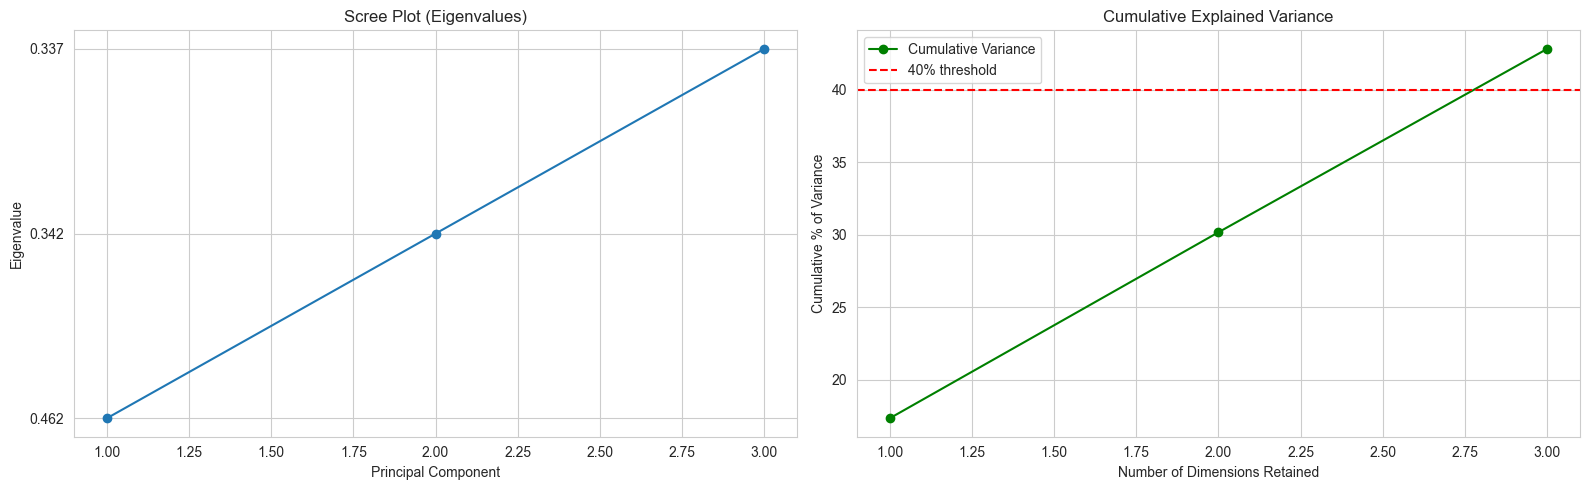

In [81]:
plot_mca_contributions(mca_full, 0.40)

#### Main

In [82]:
mca = MCA(
        n_components=2,
        n_iter=10,
        copy=True,
        check_input=True,
        engine="sklearn",
        random_state=42,
        one_hot=True,
    )
mca = mca.fit(df_categorical)

In [83]:
mca.eigenvalues_summary

,eigenvalue,% of variance,% of variance (cumulative)
component,,,
0,0.462,17.34%,17.34%
1,0.342,12.83%,30.16%


In [84]:
mca.plot(
    df_categorical,
    x_component=0, y_component=1,
    show_column_markers=True,
    show_row_markers=False,
    show_column_labels=False,
    show_row_labels=False
)

alt.LayerChart(...)

In [85]:
mca.column_contributions_.head()

,0,1
cloud_cover__clear,0.116833,0.009640
cloud_cover__cloudy,0.020929,0.413153
cloud_cover__overcast,0.156763,0.005768
cloud_cover__partly cloudy,0.032409,0.045578
season__Autumn,0.071915,0.061456


In [86]:
get_mca_contribution_table(mca, percent=True)

,Dim1,Dim2
cloud_cover,32.69 %,47.41 %
season,40.75 %,50.48 %
location,26.55 %,2.11 %
Total,100.0 %,100.0 %


## Classification & segregation of labeled groups

In [87]:
print(variablies)
print(target)

['temperature', 'humidity', 'wind_speed', 'precipitation_(%)', 'atmospheric_pressure', 'visibility_(km)', 'cloud_cover', 'season', 'location', 'uv_index']
['weather_type']


In [88]:
df_num = df_numerical.copy()
df_cate = df_categorical.copy()

df_num_pre = preprocessing_numerical(df_num, numerical_cols) if numerical_cols else pd.DataFrame()
df_cate_pre = (
    preprocessing_categorical(df_cate, nominal_cols=categorical_cols)
    if categorical_cols
    else pd.DataFrame()
)

df_for_da = pd.concat([df_num_pre, df_cate_pre], axis=1)

In [89]:
print(df_for_da.head())
print(df_target.head())

   temperature  humidity  wind_speed  precipitation_(%)  atmospheric_pressure  \
0    -0.294931  0.212404   -0.048086           0.887629              0.134203   
1     1.143035  1.351385   -0.192836           0.543291              0.150602   
2     0.625367 -0.233285   -0.409962          -1.178401              0.346579   
3     1.085516  0.707613   -1.206089           0.887629              0.549008   
4     0.452811  0.261924    1.037543           0.386773             -0.407490   

   visibility_(km)  uv_index  cloud_cover_cloudy  cloud_cover_overcast  \
0        -0.582231 -0.520104                 0.0                   0.0   
1         1.345768  0.776424                 0.0                   0.0   
2         0.010999  0.257813                 0.0                   0.0   
3        -1.323769  0.776424                 0.0                   0.0   
4        -0.878846 -0.779410                 0.0                   1.0   

   cloud_cover_partly cloudy  season_Spring  season_Summer  season_W

In [90]:
X_train, X_test, y_train, y_test = train_test_split(df_for_da, df_target, stratify=df_target, test_size=0.2, random_state=42)

### LDA (Linear Discriminant Analysis)

In [91]:
lda = LinearDiscriminantAnalysis()
lda.fit(X_train, y_train)
lda_pred = lda.predict(X_test)

In [92]:
print("Confusion Matrix:")
print(confusion_matrix(y_test, lda_pred))

print("\nClassification Report:")
print(classification_report(y_test, lda_pred))

Confusion Matrix:
[[566  71  19   4]
 [ 45 546  68   1]
 [ 45  12 601   2]
 [150  23  15 472]]

Classification Report:
              precision    recall  f1-score   support

           0       0.70      0.86      0.77       660
           1       0.84      0.83      0.83       660
           2       0.85      0.91      0.88       660
           3       0.99      0.72      0.83       660

    accuracy                           0.83      2640
   macro avg       0.84      0.83      0.83      2640
weighted avg       0.84      0.83      0.83      2640



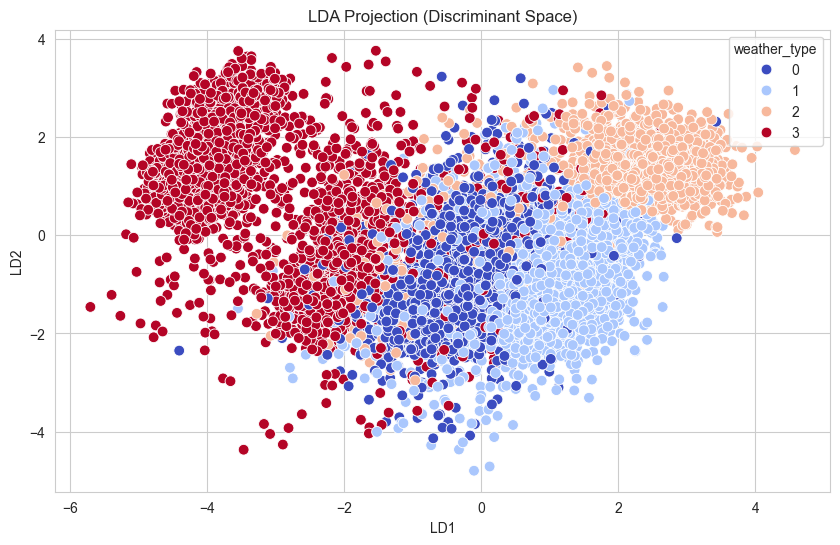

In [93]:
X_lda = lda.transform(df_for_da)

plt.figure(figsize=(10, 6))
sns.scatterplot(
    x=X_lda[:, 0],
    y=X_lda[:, 1] if X_lda.shape[1] > 1 else [0] * len(X_lda),
    hue=df_target[target[0]],
    palette="coolwarm",
    s=60,
)
plt.title("LDA Projection (Discriminant Space)")
plt.xlabel("LD1")
if X_lda.shape[1] > 1:
    plt.ylabel("LD2")
plt.grid(True)
plt.show()

In [94]:
lda_weights = pd.Series(lda.coef_[0], index=df_for_da.columns)
top_features = lda_weights.abs().sort_values(ascending=False).head(10)

print("Top 10 important features for class separation:")
print(top_features)

Top 10 important features for class separation:
cloud_cover_partly cloudy    3.235248
cloud_cover_overcast         2.854903
cloud_cover_cloudy           2.001117
precipitation_(%)            0.906143
season_Winter                0.846620
visibility_(km)              0.702584
temperature                  0.649753
humidity                     0.330927
location_mountain            0.327537
location_inland              0.282131
dtype: float64


## Uncovering hidden structures & latent groupings

#### Separate variables into feasible combinations.

In [95]:
# Weather conditions
weather_cols = [
    "temperature",
    "humidity",
    "wind_speed",
    "precipitation_(%)",
    "atmospheric_pressure",
    "visibility_(km)",
    "cloud_cover",
    "uv_index"
]

# Location & Seasonality
seasonal_cols = ["season", "location"]

combinations = [weather_cols] + [seasonal_cols]
combinations_name = ["weather_cols", "seasonal_cols"]

In [96]:
df_for_cluster = df[weather_cols+seasonal_cols].copy()

### Kmeans

Run KMeans clustering for: weather_cols
KMeans optimization:
- Optimal number of clusters: 2
- Silhouette Score: 0.300


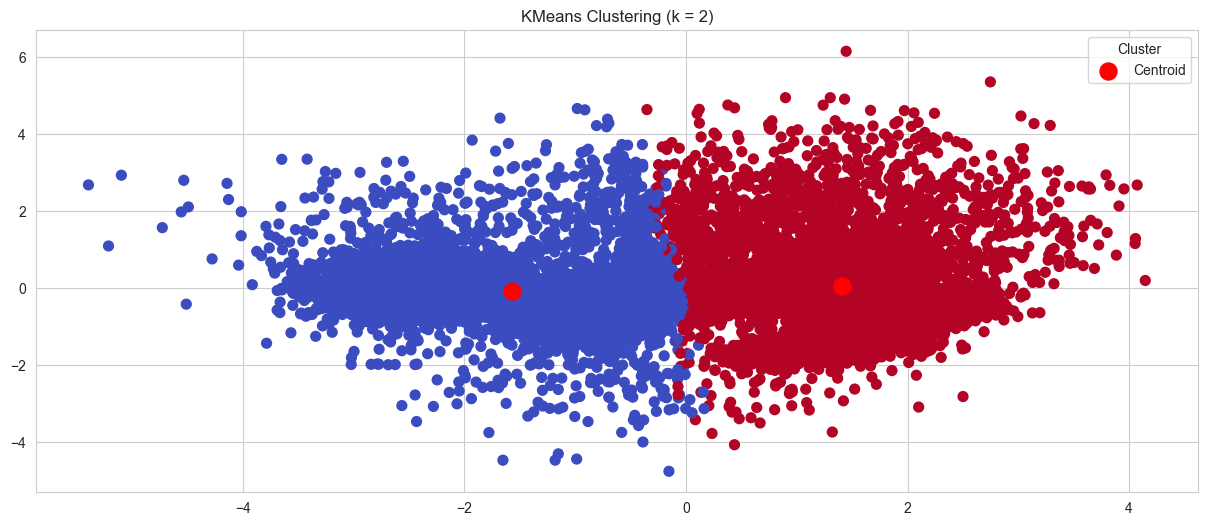


Run KMeans clustering for: seasonal_cols
KMeans optimization:
- Optimal number of clusters: 10
- Silhouette Score: 0.855


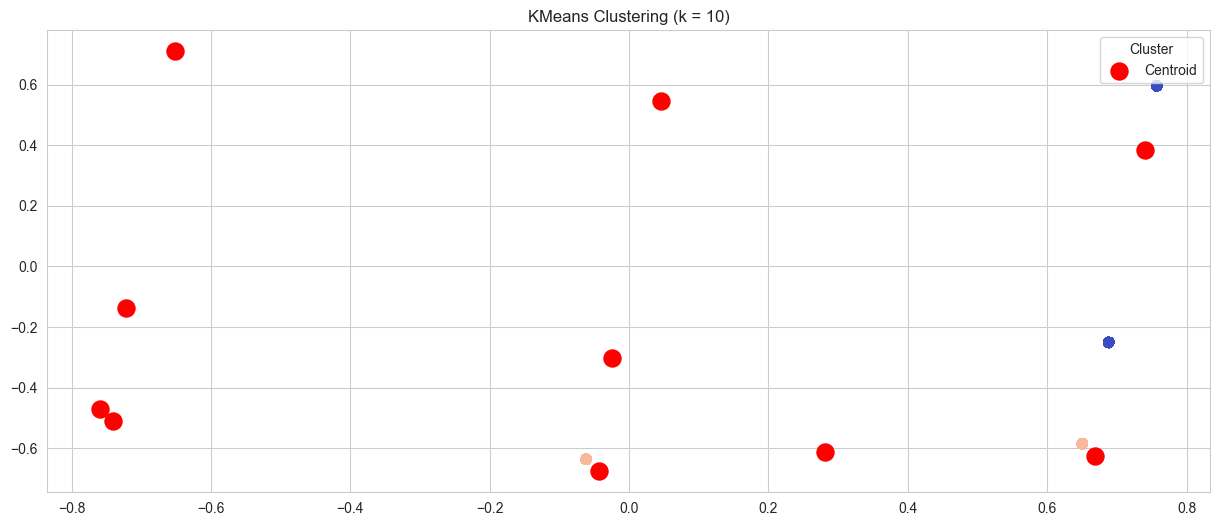

In [97]:
for obj, name in zip(combinations, combinations_name):
    print(f"Run KMeans clustering for: {name}")
    df_for_cluster[f"cluster_{name}"] = run_kmeans_clustering(df[obj].copy(), cluster_range=range(2, 11))
    print()

### Analysis

In [98]:
for obj, name in zip(combinations, combinations_name):
    print(f"Cluster counts for: {name}")
    print(df_for_cluster[obj + [f"cluster_{name}"]].value_counts(subset=[f"cluster_{name}"]))
    print("-"*50)

Cluster counts for: weather_cols
cluster_weather_cols
1                       6956
0                       6244
Name: count, dtype: int64
--------------------------------------------------
Cluster counts for: seasonal_cols
cluster_seasonal_cols
0                        3166
1                        2308
6                        1644
5                         930
3                         900
2                         888
8                         859
7                         851
4                         848
9                         806
Name: count, dtype: int64
--------------------------------------------------


<Axes: xlabel='uv_index', ylabel='Count'>

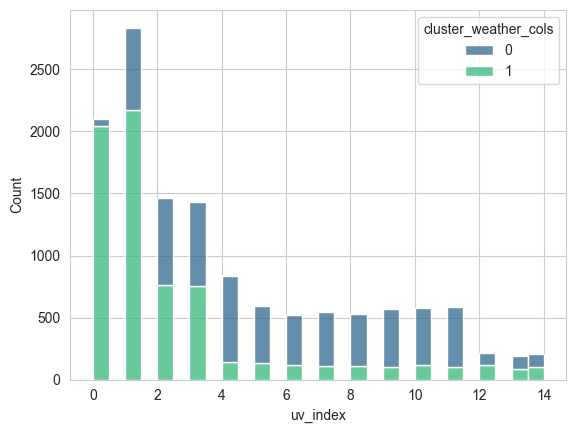

In [99]:
sns.histplot(
    data=df_for_cluster[weather_cols + ["cluster_weather_cols"]],
    x="uv_index",
    hue="cluster_weather_cols",
    multiple="stack",
    palette="viridis",
)

## Investigating the association between two variables

### Separate variables into feasible combinations

In [100]:
group_A = weather_cols
group_B = seasonal_cols

In [101]:
df_A_B_for_cca = df[group_A+group_B]

### Main

In [102]:
X_a = df[group_A]
X_b = df[group_B]

X_a, X_b = X_a.align(X_b, join='inner', axis=0)

In [103]:
def preprocessing_for_cca(df: pd.DataFrame):
    num_cols, cate_cols, _ = group_columns_by_type(df, False)
    if num_cols:
        df[num_cols] = preprocessing_numerical(df[num_cols], numerical_cols=num_cols, is_return_scaler=False)
    if cate_cols:
        df = pd.concat([df, preprocessing_categorical(df[cate_cols], nominal_cols=cate_cols)], axis = 1)
        df.drop(columns=cate_cols, axis=1, inplace=True)
    return df

In [104]:
X_a_scaled = preprocessing_for_cca(X_a)
X_b_scaled = preprocessing_for_cca(X_b)

In [105]:
n_components_cca = min(X_a.shape[1], X_b.shape[1])
cca = CCA(n_components=n_components_cca)
X_a_c, X_b_c = cca.fit_transform(X_a_scaled, X_b_scaled)

In [106]:
corrs = [np.corrcoef(X_a_c[:, i], X_b_c[:, i])[0, 1] for i in range(n_components_cca)]
print(f"Correlation canonical: {corrs}")

Correlation canonical: [np.float64(0.5128185176486103), np.float64(0.04104586082320685)]


In [107]:
for i in range(n_components_cca):
    r = np.corrcoef(X_a_c[:, i], X_b_c[:, i])[0, 1]
    print(f"CC{i+1}: {r:.3f}")

CC1: 0.513
CC2: 0.041


In [108]:
X_a_weights = pd.DataFrame(cca.x_weights_, index=X_a_scaled.columns, columns=['CC1', 'CC2'])
X_b_weights = pd.DataFrame(cca.y_weights_, index=X_b_scaled.columns, columns=['CC1', 'CC2'])

In [109]:
def get_sorted_loadings_cca(weights: pd.DataFrame, cc: int=1):
    sorted_weights = weights[[f"CC{str(cc)}"]].copy()
    
    sorted_weights["abs_loading"] = sorted_weights[f"CC{str(cc)}"].abs()
    
    sorted_weights = sorted_weights.sort_values(by="abs_loading", ascending=False)
    
    return sorted_weights.drop(columns="abs_loading")

In [110]:
get_sorted_loadings_cca(X_a_weights, cc=1).head()

,CC1
temperature,0.874316
cloud_cover_partly cloudy,0.239005
visibility_(km),0.221862
cloud_cover_overcast,0.189368
precipitation_(%),-0.179102


In [111]:
get_sorted_loadings_cca(X_b_weights, cc=1).head()

,CC1
season_Winter,-0.888484
location_mountain,-0.334522
location_inland,-0.314152
season_Summer,0.000712
season_Spring,0.000142


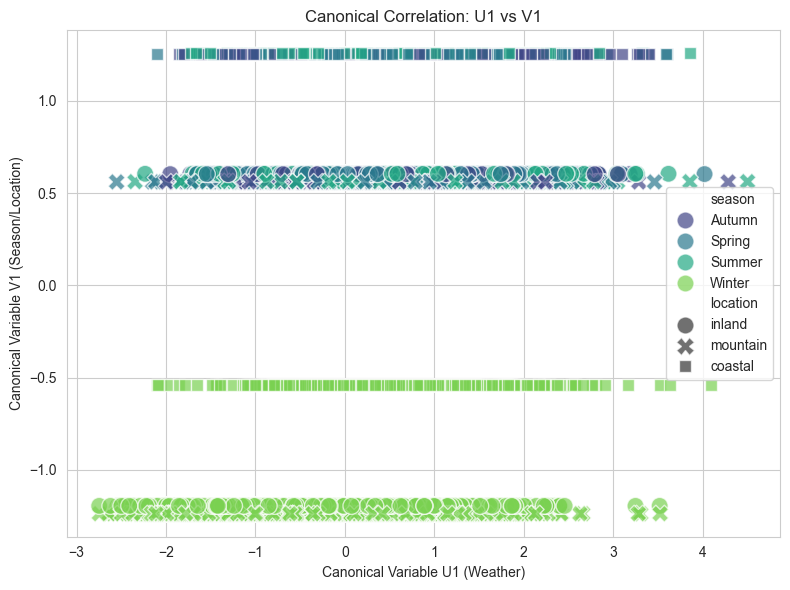

In [112]:
cca_df = pd.DataFrame({
    "U1": X_a_c[:, 0],
    "V1": X_b_c[:, 0],
    "U2": X_a_c[:, 1],
    "V2": X_b_c[:, 1],
    "season": df["season"],
    "location": df["location"]
})

plt.figure(figsize=(8, 6))
sns.scatterplot(data=cca_df, x="U1", y="V1", hue="season", style="location", palette="viridis", alpha=0.7, s=150)
plt.title("Canonical Correlation: U1 vs V1")
plt.xlabel("Canonical Variable U1 (Weather)")
plt.ylabel("Canonical Variable V1 (Season/Location)")
plt.grid(True)
plt.tight_layout()
plt.show()

# Outliers

In [113]:
outlier_list = ["temperature", "wind_speed", "atmospheric_pressure", "visibility_(km)"]

In [ ]:
df = cap_outliers_by_iqr(df, 'temperature', lower=-20, upper=50)
df = cap_outliers_by_iqr(df, 'wind_speed')
df = cap_outliers_by_iqr(df, 'visibility_(km)')

In [117]:
df = cap_outliers_by_iqr(df, 'atmospheric_pressure', lower=950, upper=1050)
df = remove_outliers_by_iqr(df, 'atmospheric_pressure')

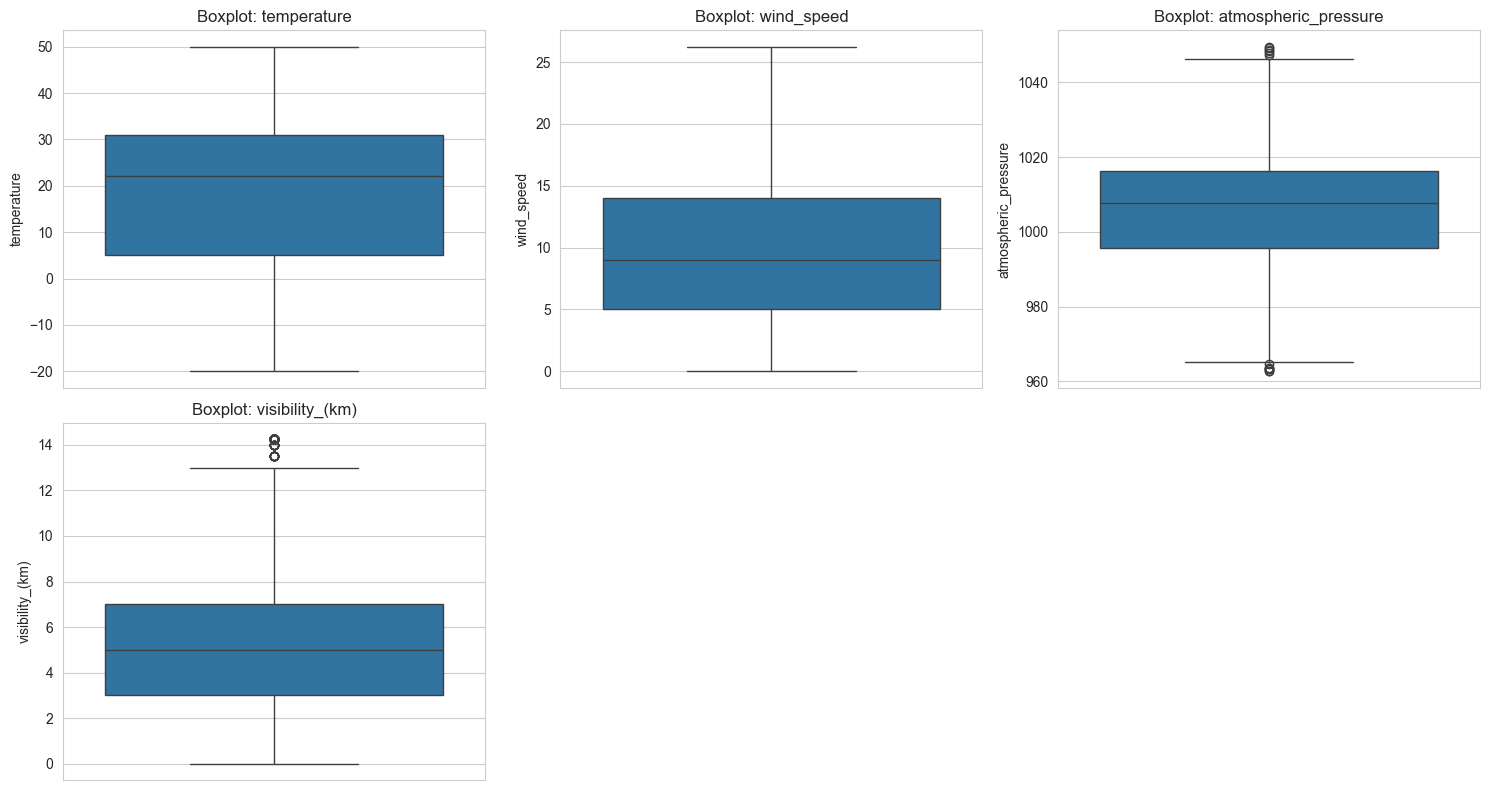

In [118]:
plot_multiple_boxplots(df, outlier_list)

# Save

In [119]:
df = pd.concat([df[numerical_cols + categorical_cols], df_target], axis=1)

## Metadata `.json`

In [ ]:
save_metadata(
    df,
    "",
)

## To `.csv`

In [ ]:
df.to_csv(
    r"",
    index=False,
    encoding="utf-8",
)